In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import h5py
import sys
sys.path.append('./../data/')
from makeCorner import *
from scipy.stats import gaussian_kde

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
results = h5py.File("./../data/birefringence_variable_evolution.hdf","r")

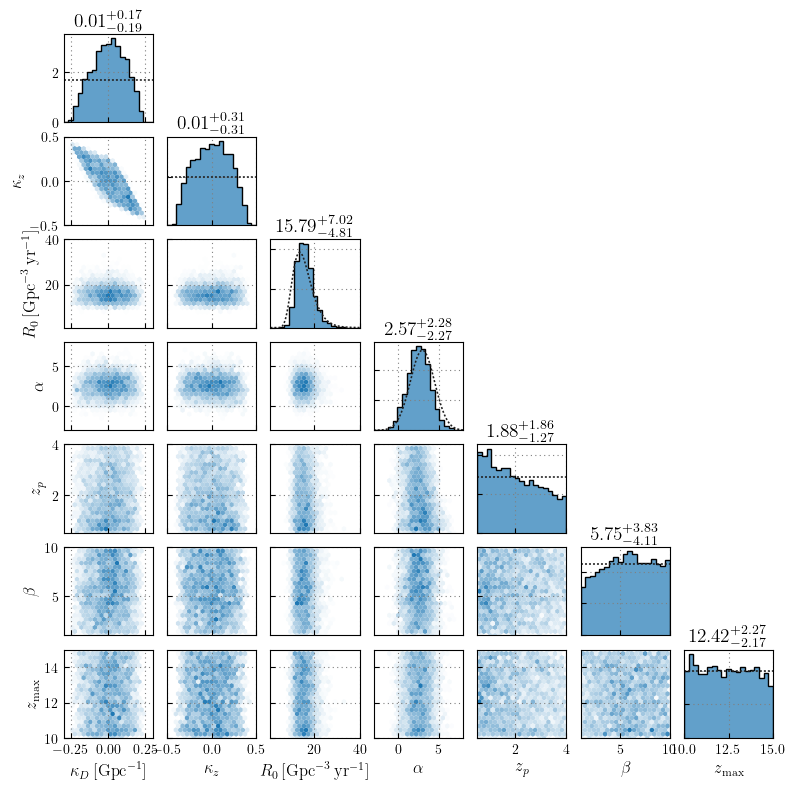

In [3]:
fig = plt.figure(figsize=(8,8))
toPlot = {
    "kappaDc":{"data":results['result']['kappa_Dc'],"plot_bounds":(-0.3,0.3),"label":r"$\kappa_D\,[\mathrm{Gpc}^{-1}]$"},
    "kappaz":{"data":results['result']['kappa_z'],"plot_bounds":(-0.5,0.5),"label":r"$\kappa_z$"},
    "R0":{"data":results['result']['R0'],"plot_bounds":(1,40),"label":r"$R_0\,[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$"},
    "alpha":{"data":results['result']['alpha'],"plot_bounds":(-3,8),"label":r"$\alpha$"},
    "zp":{"data":results['result']['zp'],"plot_bounds":(0.5,4),"label":r"$z_p$"},
    "beta":{"data":results['result']['beta'],"plot_bounds":(1,10),"label":r"$\beta$"},
    "zMax":{"data":results['result']['zMax'],"plot_bounds":(10,15),"label":r"$z_\mathrm{max}$"},
}
plot_corner(fig,toPlot,'#1f78b4',labelsize=12)

# Plot priors
axs = fig.get_axes()
axs[0].plot([-0.3,0.3],[1./0.6,1/0.6],color='#202020',dashes=(1.25,1.25),lw=1.15)
axs[7].plot([-0.5,0.5],[1.,1],color='#202020',dashes=(1.25,1.25),lw=1.15)

# Log normal prior on rate
log_Rs = np.linspace(0,np.log(40),1000)
mu_R = np.log(15.)
sig_R = np.log(20./15.)
p_log_R = np.exp(-(log_Rs-mu_R)**2/(2.*sig_R**2))/np.sqrt(2.*np.pi*sig_R**2)
axs[13].plot(np.exp(log_Rs),p_log_R/np.exp(log_Rs),color='#202020',dashes=(1.25,1.25),lw=1.15)

# Normal prior on alpha
alphas = np.linspace(-3,8,1000)
p_alphas = np.exp(-(alphas-3.)**2/(2.*1.5**2))/np.sqrt(2.*np.pi*1.5**2)
axs[18].plot(alphas,p_alphas,color='#202020',dashes=(1.25,1.25),lw=1.15)

# Uniform priors on everything else
axs[22].plot([0.5,4],[1./3.5,1./3.5],color='#202020',dashes=(1.25,1.25),lw=1.15)
axs[25].plot([1,10],[1./9.,1./9.],color='#202020',dashes=(1.25,1.25),lw=1.15)
axs[27].plot([10,15],[1./5,1/5],color='#202020',dashes=(1.25,1.25),lw=1.15)

plt.subplots_adjust(wspace=0.16,hspace=0.16)
plt.savefig('figure_07.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [4]:
kd = results['result']['kappa_Dc'][()]
kz = results['result']['kappa_z'][()]
posterior_kde = gaussian_kde(np.array([kd,kz]),bw_method=0.1)

kd_array = np.linspace(-0.3,0.3,1000)
p_kd_conditioned = posterior_kde(np.array([kd_array,np.zeros_like(kd_array)]))
p_kd_conditioned /= np.trapz(p_kd_conditioned,kd_array)
cdf_kd_conditioned = np.cumsum(p_kd_conditioned)/np.trapz(p_kd_conditioned)

kz_array = np.linspace(-0.65,0.65,1000)
p_kz_conditioned = posterior_kde(np.array([np.zeros_like(kz_array),kz_array]))
p_kz_conditioned /= np.trapz(p_kz_conditioned,kz_array)
cdf_kz_conditioned = np.cumsum(p_kz_conditioned)/np.trapz(p_kz_conditioned)

In [5]:
def quantiles_to_errors(q05,q50,q95):
    return q50,q95-q50,q50-q05

# Save our fitting results
with open('./variableEvolution_results.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\VariableRateKappaDcMarginal}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".\
                    format(*quantiles_to_errors(np.quantile(kd,0.05),np.quantile(kd,0.5),np.quantile(kd,0.95))))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\VariableRateKappaZMarginal}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".\
                    format(*quantiles_to_errors(np.quantile(kz,0.05),np.quantile(kz,0.5),np.quantile(kz,0.95))))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\VariableRateKappaDcConditioned}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".\
                    format(*quantiles_to_errors(np.interp(0.05,cdf_kd_conditioned,kd_array),
                                                np.interp(0.50,cdf_kd_conditioned,kd_array),
                                                np.interp(0.95,cdf_kd_conditioned,kd_array))))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\VariableRateKappaZConditioned}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".\
                    format(*quantiles_to_errors(np.interp(0.05,cdf_kz_conditioned,kz_array),
                                                np.interp(0.50,cdf_kz_conditioned,kz_array),
                                                np.interp(0.95,cdf_kz_conditioned,kz_array))))
    macrofile.write("\n")